# Predicting Pedestrian counting in Melbourn city through Time Series analysis and ARIMA forecasting

In this work a dataset containing information about the flux of people in various points of the city of Melbourne (Australia) is analysed, and a forecasting method is applied with the aim of predicting the count of pedestrains crossing a particular area.

The dataset can be consulted for free in the official website: http://www.pedestrian.melbourne.vic.gov.au/#date=24-05-2022&time=15

Firstly we import the libraries needed for the preproceessing and the forecasting:

In [1]:
import pandas as pd                         # 
import numpy as np                          # for dataset preprocessing
import matplotlib.pyplot as plt             #

import os                                   # for new_read function definition
import glob                                 #

from datetime import timedelta              #
import pmdarima as pm                       # for arima model implementation
from pmdarima.arima import auto_arima       #

The dataset consists in a csv containing the count per hour of detected pedestrians trespassing a sensor installed in each of the 79 locations monitored in the city of Melbourne; eventually, some locations will appear more than once because a subgroup of the sensors is able to distinguish between direction of movement (north, east, west or south).

The features (columns) of the csv can be summarized as follows:
1. **Date:** the day during which the counting was recorded;
2. **Hour:** the hour (of the day) during which the counting was recorded;
3. **Locations:** the location (and direction, if provided) in which the counting was recorded.

In [2]:
df = pd.read_csv("..\\April_2022.csv")          # last month of April is taken as an example
df

,Date,Hour,Bourke Street Mall (North),Bourke Street Mall (South),Melbourne Central,Town Hall (West),Princes Bridge,Flinders Street Station Underpass,Birrarung Marr,Webb Bridge,...,Flinders St - ACMI,Bourke St - Spencer St (South),Spring St - Flinders St (West),Macaulay Rd - Bellair St,Harbour Esplanade - Pedestrian Path,Harbour Esplanade - Bike Path,Flinders St (South),Elizabeth St - Flinders St (East) - New footpath,Macaulay Rd (North),Queensberry St - Errol St (South)
0,01/04/2022,0,56,88,380,317,261,202,na,6,...,92,na,8,na,7,5,97,220,2,7
1,01/04/2022,1,41,56,198,107,85,99,na,4,...,176,na,1,1,4,2,56,109,1,2
2,01/04/2022,2,26,28,137,63,47,74,na,1,...,27,na,na,na,5,1,24,74,1,1
3,01/04/2022,3,8,11,81,29,57,32,na,1,...,5,na,2,1,2,1,19,47,na,na
4,01/04/2022,4,8,8,76,24,70,44,2,2,...,9,na,4,na,na,3,27,55,na,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,30/04/2022,19,1090,489,2272,1641,1927,1385,88,160,...,777,na,258,76,462,47,1132,1479,126,110
716,30/04/2022,20,666,403,2172,1239,1567,1208,4,101,...,558,na,69,33,103,25,793,1352,46,64
717,30/04/2022,21,448,310,1833,1083,1695,988,4,88,...,457,na,31,22,76,15,728,1015,13,50
718,30/04/2022,22,532,445,1582,883,1246,1135,53,278,...,404,na,51,20,133,221,759,1048,16,34


The function `new_read` is defined in order to read and preprocess the csv file, adding the value of the **hour** (originally in a separated column) to the column that refers to the **date** (the actual timestamp), before setting it as the index of the dataframe.

In our case the months of February and March of year 2022 were selected, while the location for the forecast was chosen to be *Melbourne Central*:

In [3]:
# function for reading the csv
global location
location = "Melbourne Central"
def new_read(csv,total_hrs=None):
    df = pd.read_csv(csv)
    df = df[["Date","Hour",location]]
    df[location] = pd.to_numeric(df[location],errors="coerce")
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
    df = df[["Date",location]]
    df.set_index("Date", drop=True, inplace=True)
    if total_hrs:                                            # enables to load only a portion of the dataset
        df = df[:total_hrs]
    return df

The two (or more) files that contain the data collected during the selected months are loaded and concatenateted to form a single dataframe:

In [4]:
files = os.path.join("..\\dataset\\monthly\\", "ds*.csv")
files = glob.glob(files)
df = pd.concat(map(new_read, files))
df

,Melbourne Central
Date,
2022-02-01 00:00:00,237
2022-02-01 01:00:00,173
2022-02-01 02:00:00,92
2022-02-01 03:00:00,36
2022-02-01 04:00:00,42
...,...
2022-03-31 19:00:00,1767
2022-03-31 20:00:00,1461
2022-03-31 21:00:00,1433


Any **NaN** value is dropped so as to preserve the correct functioning of the model: 

In [5]:
df = df.dropna()
df

,Melbourne Central
Date,
2022-02-01 00:00:00,237
2022-02-01 01:00:00,173
2022-02-01 02:00:00,92
2022-02-01 03:00:00,36
2022-02-01 04:00:00,42
...,...
2022-03-31 19:00:00,1767
2022-03-31 20:00:00,1461
2022-03-31 21:00:00,1433


To visualize the data we plot the dataframe we obtained:

<AxesSubplot:xlabel='Date'>

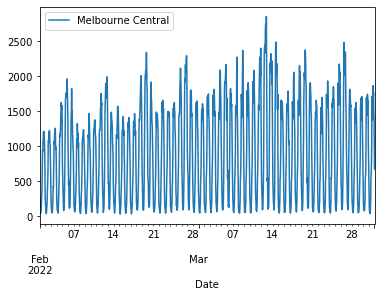

In [6]:
df.plot(kind = 'line')

Now we need to make sure that the dataset is *stationary*, namely that it has fixed mean and variance.

We can achieve this using the function `ADFTest` from the module `pmdarima`; if the resulting *p-value* is lower than the selected acceptance level $\alpha$ (in our case $\alpha$ = 0.05), then we can conclude that the dataset is indeed stationary, otherwise, *differentiation* is needed to force stationarity:

In [7]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

(0.01, False)

Now we split the dataset into *test* and *train* set, respectively the last 48 hours and all the previous remaining ones:

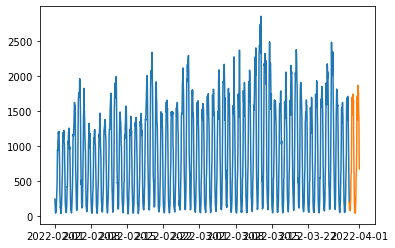

In [8]:
train = df[:-47]
test = df[-48:]
plt.plot(train)
plt.plot(test)

We have all we need to train the forecasting model; a seasonal <font color='green'>ARIMA</font> model is implemented and fit with the help of the `auto_arima` function:

In [12]:
arima_model = auto_arima(train, start_p=0, d=1, start_q=0,max_p=5, 
                         max_d=5, max_q=5, start_P=0,D=1, start_Q=0,
                         max_P=5, max_D=5,max_Q=5,m=12,seasonal=True,
                         error_action='warn',trace=True,supress_warnings=True,
                         stepwise=True, random_state=20,n_fits=50)

arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=20079.463, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.82 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=17380.470, Time=0.81 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=6.39 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=5.81 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=3.52 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=9.72 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=17375.920, Time=4.81 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.81 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=11.53 sec
 ARIMA(1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1369
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8683.888
Date:                            Tue, 24 May 2022   AIC                          17375.776
Time:                                    08:33:04   BIC                          17396.625
Sample:                                         0   HQIC                         17383.583
                                           - 1369                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0762      0.021     -3.601      0.000      -0.118      -0.035
ar.S.L12      -0.9093      0.010    -87.542      0.000      -0.930      -0.889
ma.S.L12      -0.2149      0.026     -8.204      0.000      -0.266      -0.164
sigma2      2.102e+04    528.764     39.759      0.000       2e+04    2.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               590.16
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now that the model is trained we can plot useful diagnostics about it:
* **Top left:** *residual errors*;
* **Top Right:** *density plot*;
* **Bottom Left:** *normal Q-Q*;
* **Bottom Right:** *Correlogram*:

q:\Snake\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


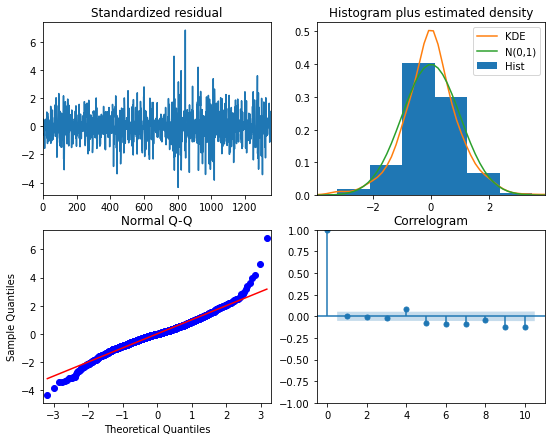

In [13]:
arima_model.plot_diagnostics(figsize=(9,7))
plt.show()

In the end we evaluate the prediction of the model on the next 48 hours following the train set (i.e. the test set):

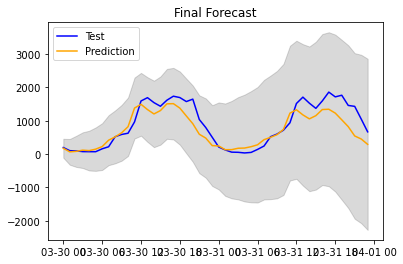

In [14]:
# Forecast
n_periods = len(test)
fc, confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)


index_of_fc = test.index

# Make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)                      # array of predictions
lower_series = pd.Series(confint[:, 0], index=index_of_fc)        # lower bound of confidence interval
upper_series = pd.Series(confint[:, 1], index=index_of_fc)        # higher bound of confidence interval

# Plot
plt.plot(test, color="blue", label='Test')
plt.plot(fc_series, color='orange', label='Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.legend(loc ='upper left')
plt.show()

We can conclude that the model prediction is very close to the real value of the count of pedestrians in the 48 hours of the test set, so, at least for the first two days, the algorithm is capable of predicting the flux of people in a certain area (for sure within its confidence interval). The model thus far looks promising and further research could be done in order to try to generalize the analysis to a broader time interval (days, months or even years); this type of generalization has been considered but discarded at first because an hourly-based division of timestamps seemed to be the most regular and stationary, while external factors (such as opening/closing days of activities, lockdowns etc.) must be taken in cause in a greater time interval focus, nevertheless, a weekly based analysis seems to be next plausible subdivision, given the regolarity of the days and the cycle of social activities from Monday to Sunday; further research shall be conducted. 